# Task 7 – Sales Forecasting

**Objective:**  
Forecast Walmart sales using historical weekly data.  

**Steps:**  
1. Load and explore dataset  
2. Time-based feature engineering  
3. Train/test split by time  
4. Apply regression model (XGBoost/Linear Regression)  
5. Evaluate with MAE, RMSE  
6. Plot actual vs predicted sales


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression


In [2]:
df = pd.read_csv("Walmart.csv")

print("Shape:", df.shape)
df.head()


Shape: (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [3]:
# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Sort values by date
df = df.sort_values("Date")



<class 'pandas.core.frame.DataFrame'>
Index: 6435 entries, 177 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          2565 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 452.5 KB


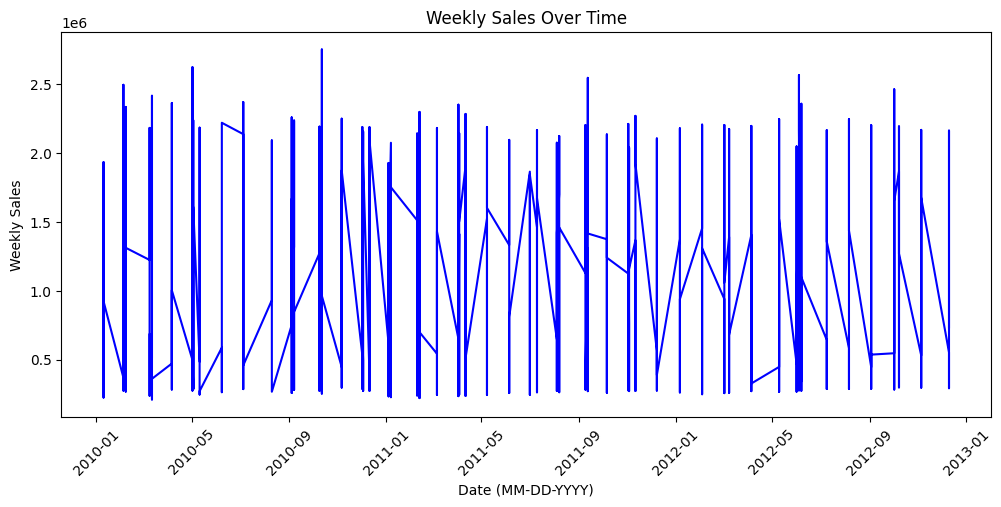

In [4]:
#df["Date"] = df["Date"].dt.strftime("%m-%d-%Y")  # format as Month-Day-Year
df["Date"] = pd.to_datetime(df["Date"], format="%m-%d-%Y")  # ensure datetime type

# Sort by Date
df = df.sort_values("Date")

# Info
df.info()

# Plot sales trend with formatted dates
plt.figure(figsize=(12,5))
plt.plot(df["Date"], df["Weekly_Sales"], color="blue")
plt.title("Weekly Sales Over Time")
plt.xlabel("Date (MM-DD-YYYY)")
plt.ylabel("Weekly Sales")
plt.xticks(rotation=45)  # rotate for readability
plt.show()


In [5]:
# Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop rows with invalid/missing dates
df = df.dropna(subset=["Date"])

# Extract features
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month

# For Week, use isocalendar which returns a DataFrame
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)

features = ["Year", "Month", "Week"]
X = df[features]
y = df["Weekly_Sales"]

print("Feature sample:")
print(X.head())


Feature sample:
      Year  Month  Week
177   2010      1     1
1464  2010      1     1
4896  2010      1     1
2894  2010      1     1
4467  2010      1     1


In [6]:
# Split data 80% train, 20% test (by time)
split_index = int(len(df) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (2052, 3)
Test size: (513, 3)


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter grid for Random Forest
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

# Initialize Random Forest
rf = RandomForestRegressor(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,                # number of random combinations
    cv=3,                     # 3-fold cross-validation
    scoring="neg_mean_squared_error",
    verbose=2,
    random_state=42,
    n_jobs=-1                 # use all CPU cores
)

# Fit search on training set
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)

# Use the best estimator
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.7s
[CV] END max_depth=None, max_features=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=30, max_features=None, min_samples_leaf=2, min_samples_split=5, n_estimato

In [20]:
from sklearn.metrics import  root_mean_squared_error

mse = root_mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE : {rmse:.2f}")


RMSE : 752.02


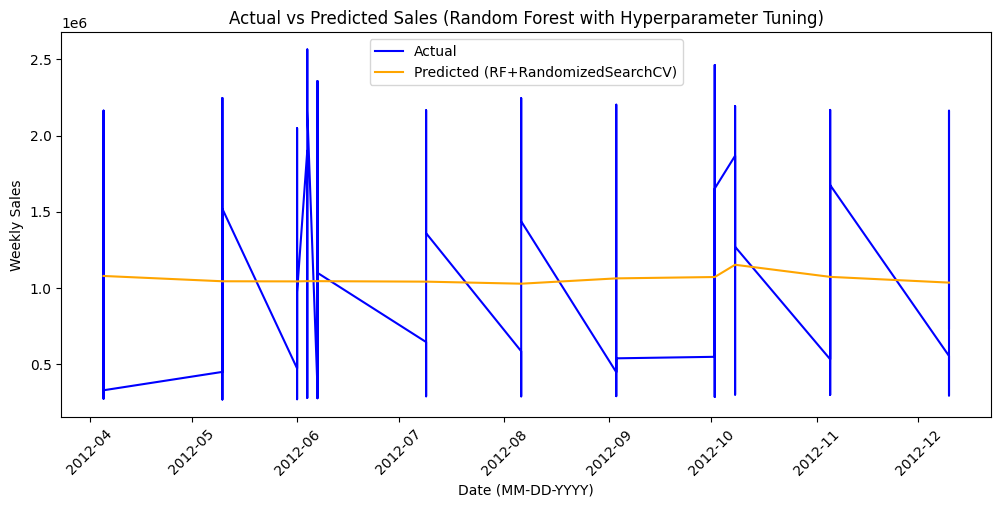

In [21]:
plt.figure(figsize=(12,5))
plt.plot(df["Date"].iloc[split_index:], y_test, label="Actual", color="blue")
plt.plot(df["Date"].iloc[split_index:], y_pred, label="Predicted (RF+RandomizedSearchCV)", color="orange")
plt.xlabel("Date (MM-DD-YYYY)")
plt.ylabel("Weekly Sales")
plt.title("Actual vs Predicted Sales (Random Forest with Hyperparameter Tuning)")
plt.xticks(rotation=45)
plt.legend()
plt.show()
